# Process Raw Audio Files



In [1]:
# Start loop through audio file
# Load Audio file
# Set audio start time based on audio file name
# Create a time axis for the audio file based on start time, duration and samplerate
# Align time axis with audio data
# If value in csv is within audio file time range, process it
    # If yes, extract audio clip with start time from csv with duration
# Else skip to next audio file

In [2]:
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
import os
from datetime import datetime, timedelta
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:

def get_start_time_from_filename(file_path: Path, 
                                 dt_format: str="%Y%m%d_%H%M%S") -> datetime:
    """
    Extracts the start time from the audio filename.
    Parameters:
    file_path (Path): The path to the audio file.
    dt_format (str): The datetime format used in the filename.
    Returns:
    datetime: The extracted start time as a datetime object.
    Raises:
    ValueError: If the filename does not match the expected format.
    """

    try:
        # Remove suffix and parse datetime from the stem
        dt = datetime.strptime(file_path.stem, dt_format)
    except ValueError:
        raise ValueError(
            f"Filename '{file_path.name}' does not match expected format 'YYYYMMDD_HHMMSS.WAV'."
        )
    return dt

def generate_time_axis(start_time: datetime, 
                       data: np.ndarray, samplerate: int) -> np.ndarray:
    """
    Generates a time axis for the audio data.
    Parameters:
    start_time (datetime): The start time of the audio recording.
    data (np.ndarray): The audio data array.
    samplerate (int): The sample rate of the audio data.
    Returns:
    np.ndarray: An array of datetime64 objects representing the time axis.
    """
    n_samples = data.shape[0]
    start_time = np.datetime64(start_time)
    time_axis = start_time + np.arange(n_samples) / samplerate * np.timedelta64(1, 's')

    # Test to make sure shapes match
    assert data.shape == time_axis.shape

    return time_axis

In [4]:
# Read CSV file with timestamps and durations
file_path = Path.cwd() / 'csv'

#read all csv files in directory
csv_files = [f for f in file_path.glob('*.csv')]
csv_files


[PosixPath('/home/dorian/Oslo-Wave-Tank-RAW-Data-Processing/csv/OsloWaveTankLog2D.csv')]

In [5]:
# Read csv file and display head

for file in csv_files:
    df = pd.read_csv(file)

df.head()

,ID,Run,Date,Time (ThinkPad DS) [UTC],Time (Wave Tank Computer) [UTC],Focus Point (x) [m],Hs,Preak Period [s],Freq (max) [Hz],Freq (Min) [Hz],Notes
0,101,1,2025-10-29,11:22:00,11:19:18,11.0,0.05,2.0,1.8,0.1,"No Wave Gage Measurement, Gain to high, For al..."
1,102,1,2025-10-29,11:25:00,11:22:18,11.0,0.05,2.0,1.8,0.1,Gain to high
2,103,1,2025-10-29,11:27:00,11:24:18,11.0,0.05,2.0,1.8,0.1,"No Wave Gage Measurement, Gain to high"
3,104,1,2025-10-29,11:30:00,11:27:18,11.0,0.05,2.0,1.8,0.1,Gain to high
4,105,2,2025-10-29,11:45:00,11:42:18,11.0,0.05,2.0,1.8,0.1,NaN


In [6]:
id = df['ID']
date = df['Date']
time_UTC = df['Time (ThinkPad DS) [UTC]']

# Convert date and time to datetime object with format YYYY-MM-DD HH:MM:SS
date_time_UTC = pd.to_datetime(date + ' ' + time_UTC, format='%Y-%m-%d %H:%M:%S')
date_time_UTC.head()

0   2025-10-29 11:22:00
1   2025-10-29 11:25:00
2   2025-10-29 11:27:00
3   2025-10-29 11:30:00
4   2025-10-29 11:45:00
dtype: datetime64[ns]

In [7]:
# Load all audio files
audio_path = Path.cwd() / 'input'
file_types = '*.WAV'  # the tuple of file types
audio_files = sorted([f for f in audio_path.glob(file_types)])

# HACK
audio_file = audio_files[0]
audio_file.stem

'20251029_111922'

In [8]:
# Read audio file
samplerate, data = wav.read(audio_file)
data.shape, samplerate

memory_size = data.size * data.itemsize
memory_size/1e6 # Unit: MB

/tmp/ipykernel_10461/511447808.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wav.read(audio_file)


82.214424

In [9]:
# Determine audio recording duration
duration = 1e9 * data.shape[0] / samplerate # units: seconds [ns]

In [10]:
# Read start time from audio file name:
start_time = get_start_time_from_filename(audio_file)
start_time

datetime.datetime(2025, 10, 29, 11, 19, 22)

In [11]:
int(start_time.timestamp() * 1e9)  # units: nanoseconds

1761733162000000000

In [12]:
# Generate recording time axis
rec_times_axis = np.linspace(0, duration, len(data))
rec_times_axis

array([0.00000000e+00, 2.08333338e+04, 4.16666677e+04, ...,
       8.56400208e+11, 8.56400229e+11, 8.56400250e+11], shape=(41107212,))

In [13]:

rts = rec_times_axis.astype('timedelta64[ns]') + pd.to_datetime(start_time)
#rt = pd.to_timedelta(rec_time_axis, unit='ns') + pd.to_datetime(get_start_time_from_filename(audio_file))
rts

array(['2025-10-29T11:19:22.000000000', '2025-10-29T11:19:22.000020833',
       '2025-10-29T11:19:22.000041666', ...,
       '2025-10-29T11:33:38.400208333', '2025-10-29T11:33:38.400229166',
       '2025-10-29T11:33:38.400250000'],
      shape=(41107212,), dtype='datetime64[ns]')

In [14]:
rts.size * rts.itemsize / 1e6  # Unit: MB

328.857696

In [15]:
arr_int = rts.astype('int64')
arr_int

array([1761736762000000000, 1761736762000020833, 1761736762000041666, ...,
       1761737618400208333, 1761737618400229166, 1761737618400250000],
      shape=(41107212,))

In [16]:
arr_int.size * arr_int.itemsize / 1e6  # Unit: MB

328.857696

In [17]:
data.dtype

dtype('int16')

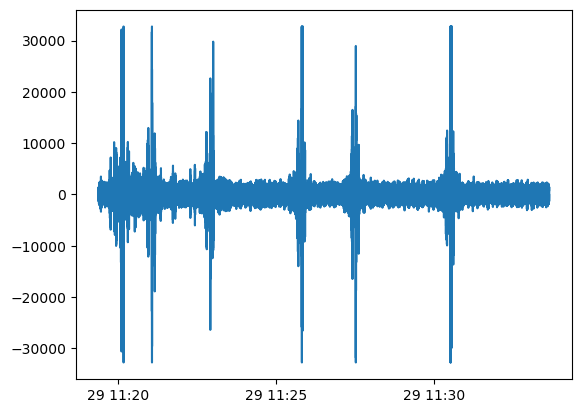

In [18]:
step = 100 # or pick dynamically: len(data)//1_000_000 for ~1M points
idx = np.arange(0, len(data), step)

plt.plot(
    pd.to_datetime(start_time) + rec_times_axis[idx].astype('timedelta64[ns]'),
    data[idx]
)
plt.show()

In [19]:
rts

array(['2025-10-29T11:19:22.000000000', '2025-10-29T11:19:22.000020833',
       '2025-10-29T11:19:22.000041666', ...,
       '2025-10-29T11:33:38.400208333', '2025-10-29T11:33:38.400229166',
       '2025-10-29T11:33:38.400250000'],
      shape=(41107212,), dtype='datetime64[ns]')

In [21]:
# If rts is in nanoseconds (int64)
rts_ns = np.sort(np.array(rts, dtype=np.int64))

# Convert pandas datetime to int64 nanoseconds
dt_ns = date_time_UTC.values.astype('int64')

In [22]:
rts_ns.dtype

dtype('int64')

In [23]:
idxs = np.searchsorted(rts_ns, dt_ns)
idxs

array([ 7584000, 16224000, 21984000, 30624000, 41107212, 41107212,
       41107212, 41107212, 41107212, 41107212, 41107212, 41107212,
       41107212, 41107212, 41107212, 41107212, 41107212, 41107212,
       41107212, 41107212, 41107212, 41107212, 41107212, 41107212,
       41107212, 41107212, 41107212, 41107212, 41107212, 41107212,
       41107212, 41107212, 41107212, 41107212, 41107212, 41107212,
       41107212, 41107212, 41107212])

In [24]:
rts_min = rts_ns.min()
rts_max = rts_ns.max()

for dt in dt_ns:
    mask = (dt >= rts_min) & (dt <= rts_max)
    print(mask)


True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


41.107212